In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datetime import date
from datetime import timedelta 
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing  
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
plt.rcParams['font.family']=['Arial Unicode MS']

In [2]:
df=pd.read_csv("~/Documents/dataset/raw_data.csv", encoding='utf-8-sig')

df['下单日期'] = pd.to_datetime(df['下单日期'], errors='coerce')
df['出发时间'] = pd.to_datetime(df['出发时间'], errors='coerce')
#df.head()

i_class0 = df[df["7月是否下单"] == 0]
i_class1 = df[df["7月是否下单"] == 1]
#print(len(i_class0))
#print(len(i_class1))


#Downsampling majority class
i_class0_downsampled = resample(i_class0,
                                replace=False,
                                n_samples=len(i_class0)//10,    
                                random_state=1) 

# Combining minority class with downsampled majority class
df_downsampled = pd.concat([i_class0_downsampled, i_class1])


len(df_downsampled)

8139

In [4]:
data = {"客户编号": df_downsampled["VipNo"].unique(),
        "历史订单数量" : df_downsampled.groupby('VipNo')['出发时间'].count(),
        "历史订单总额": df_downsampled.groupby('VipNo')['订单金额'].sum(),
        "日均订单总额" : df_downsampled.groupby('VipNo').apply(lambda x: x.订单金额.sum()/x.出游天数.sum()),
        "距离上次下单时间": pd.to_datetime("2019-07-01") - df_downsampled.groupby('VipNo')['下单日期'].max(),
        "90日当月是否下单" : df_downsampled.groupby('VipNo')['下单日期'].max().between("2019-02-27","2019-03-31").astype(int),
        "平均提前预定天数" : df_downsampled.groupby('VipNo').apply(lambda x: (x.订单金额 - x.出游天数).mean() ),
        "18年7月是否下单" : df_downsampled.groupby('VipNo').apply(lambda x: x.下单日期.between("2018-07-01","2018-07-31").astype(int).max()),
        "过去1个月/12个月下单量" : (df_downsampled.assign(Quantity1=df['下单日期'].between("2019-03-01","2019-03-31")*df.订单金额)
                                               .assign(Quantity12=df['下单日期'].between("2018-03-31","2019-03-31")*df.订单金额)
                                               .groupby('VipNo')[['Quantity1','Quantity12']]
                                               .sum()
                                               .assign(output=lambda x: x['Quantity1']/x['Quantity12'])
                                               )["output"],
        "过去3个月/12个月下单量" : (df_downsampled.assign(Quantity3=df['下单日期'].between("2019-01-01","2019-03-31")*df.订单金额)
                                               .assign(Quantity12=df['下单日期'].between("2018-03-31","2019-03-31")*df.订单金额)
                                               .groupby('VipNo')[['Quantity3','Quantity12']]
                                               .sum()
                                               .assign(output=lambda x: x['Quantity3']/x['Quantity12'])
                                               )["output"],
        "过去6个月/12个月下单量" : (df_downsampled.assign(Quantity6=df['下单日期'].between("2018-10-01","2019-03-31")*df.订单金额)
                                               .assign(Quantity12=df['下单日期'].between("2018-03-31","2019-03-31")*df.订单金额)
                                               .groupby('VipNo')[['Quantity6','Quantity12']]
                                               .sum()
                                               .assign(output=lambda x: x['Quantity6']/x['Quantity12'])
                                               )["output"],
        "过去1个月/3个月下单量" : (df_downsampled.assign(Quantity1=df['下单日期'].between("2019-03-01","2019-03-31")*df.订单金额)
                                              .assign(Quantity3=df['下单日期'].between("2019-01-01","2019-03-31")*df.订单金额)
                                              .groupby('VipNo')[['Quantity1','Quantity3']]
                                              .sum()
                                              .assign(output=lambda x: x['Quantity1']/x['Quantity3'])
                                              )["output"],
        "过去3个月/6个月下单量" : (df_downsampled.assign(Quantity3=df['下单日期'].between("2019-01-01","2019-03-31")*df.订单金额)
                                              .assign(Quantity6=df['下单日期'].between("2018-10-01","2019-03-31")*df.订单金额)
                                              .groupby('VipNo')[['Quantity3','Quantity6']]
                                              .sum()
                                              .assign(output=lambda x: x['Quantity3']/x['Quantity6'])
                                              )["output"],
        "环比一个月" : (df_downsampled.assign(Quantity1=df['下单日期'].between("2019-03-01","2019-03-31")*df.订单金额)
                                    .assign(Quantity2=df['下单日期'].between("2019-02-01","2019-02-28")*df.订单金额)
                                    .groupby('VipNo')[['Quantity1','Quantity2']]
                                    .sum()
                                    .assign(output=lambda x: (x['Quantity1']-x['Quantity2'])/x['Quantity2'])
                                    )["output"],
        "18年7月/12个月下单量" : (df_downsampled.assign(Quantity7=df['下单日期'].between("2018-07-01","2019-07-31")*df.订单金额)
                                              .assign(Quantity12=df['下单日期'].between("2018-03-31","2019-03-31")*df.订单金额)
                                              .groupby('VipNo')[['Quantity7','Quantity12']]
                                              .sum()
                                              .assign(output=lambda x: x['Quantity7']/x['Quantity12'])
                                              )["output"],
        "7月是否下单":df_downsampled.groupby('VipNo')['7月是否下单'].max()
       }
              
df1 = pd.DataFrame(data)
df1.reset_index(drop=True, inplace=True)

In [5]:
#replace NaN with 0
df1["距离上次下单时间"]=df1["距离上次下单时间"].astype('timedelta64[D]')
df1 = df1.replace([np.inf, -np.inf], np.nan)
df1= df1.replace(np.nan,0)

df1.head()
#print(df1)
#df1.dtypes

,客户编号,历史订单数量,历史订单总额,日均订单总额,距离上次下单时间,90日当月是否下单,平均提前预定天数,18年7月是否下单,过去1个月/12个月下单量,过去3个月/12个月下单量,过去6个月/12个月下单量,过去1个月/3个月下单量,过去3个月/6个月下单量,环比一个月,18年7月/12个月下单量,7月是否下单
0,1001247776,1,1140.0,253.333333,957.0,0,1135.5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1602604128,1,1344.0,448.000000,262.0,0,1341.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,1815792879,1,523.0,130.750000,513.0,0,519.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1918271283,1,4141.0,345.083333,656.0,0,4129.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1918051113,1,1381.0,197.285714,336.0,0,1374.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [81]:
#spliting training and testing data
X_train, X_test, y_train, y_test = train_test_split(df1.drop(['客户编号',"7月是否下单"], axis=1), df1["7月是否下单"], test_size=0.2,random_state=1) 
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)


In [82]:
#fitting the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
real_predictions = lm.predict(X_test)
predictions = lm.predict(X_test)

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

#real_predictions = pd.DataFrame(real_predictions)
#predictions = pd.DataFrame(predictions)

In [83]:
#xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# initial set of parameters provided based on experience
xgb_param={
 'learning_rate' : 0.2,
 'n_estimators' : 120,
 'max_depth' : 3,
 'min_child_weight' : 5,
 'gamma' : 3,
 'subsample' : 0.2,
 'colsample_bytree' : 0.2,
 'objective' : 'binary:logistic',
 'eval_metric' : 'aucpr',
 'scale_pos_weight' : 12,
 'tree_method' : 'hist',
 'seed' : 732}
#模型训练
evals_result={}

model1 = xgb.train(xgb_param, dtrain, \
                   evals=[(dtrain,'dtrain')],\
                   verbose_eval=False, early_stopping_rounds=20, num_boost_round=500,\
                   callbacks=[xgb.callback.record_evaluation(evals_result)] #store results to evals result dictionary
                   )

r_predictions_xgb = model1.predict(dtest,validate_features=True, ntree_limit=model1.best_ntree_limit)
predictions_xgb = model1.predict(dtest,validate_features=True, ntree_limit=model1.best_ntree_limit)
predictions_xgb[predictions < 0.5] = 0
predictions_xgb[predictions >= 0.5] = 1


In [84]:
def eval_prc(y_test,predictions):
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, predictions)
    lr_f1 =  f1_score(y_test, predictions)
    lr_auc = auc(lr_recall, lr_precision)
    print('Model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [85]:
def eval_auc(y_test,y_pred):
    fpr,tpr,_= metrics.roc_curve(y_test,y_pred)
    plt.figure()
    plt.plot(fpr,tpr,'r',label='roc_curve')
    plt.plot([0,1],[0,1],'b')
    plt.legend(loc='best')
    plt.xlim([0,1])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0,1])
    plt.title('AUC:{}'.format(round(metrics.auc(fpr,tpr),2)))
    plt.show()

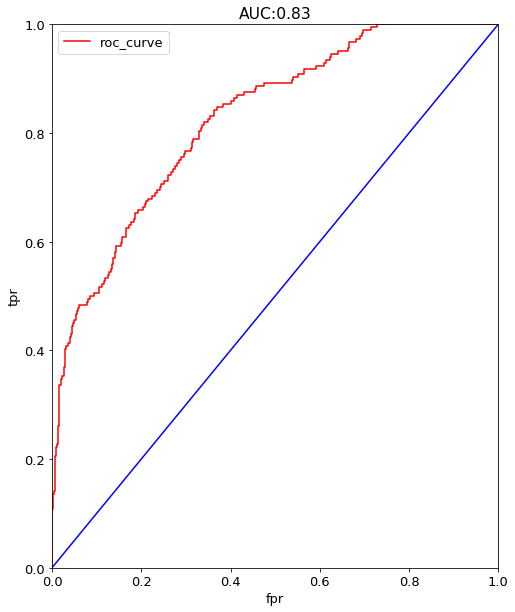

Model: f1=0.333 auc=0.612


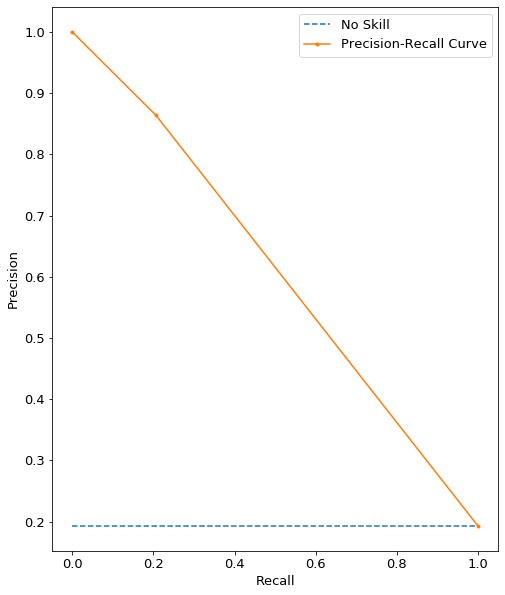

In [86]:
#linear regression
eval_auc(y_test,real_predictions)
eval_prc(y_test,predictions)

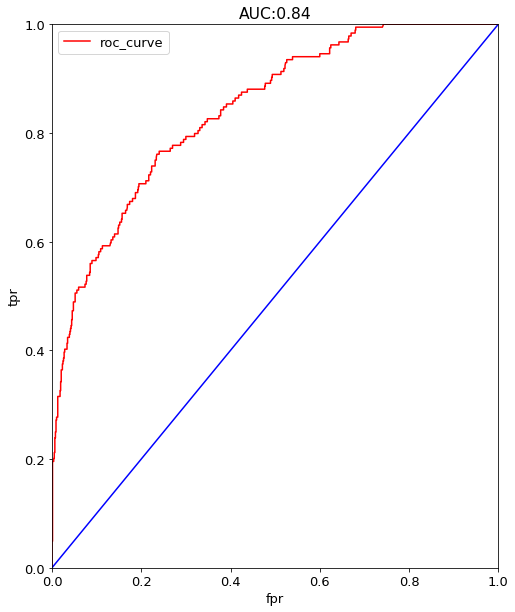

Model: f1=0.333 auc=0.612


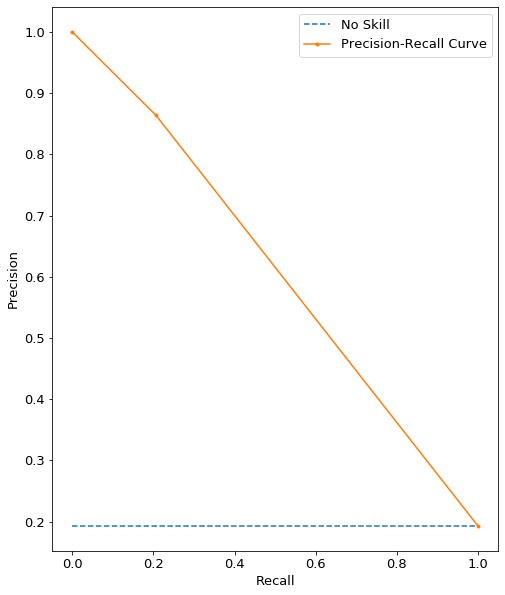

In [87]:
#boosting
eval_auc(y_test,r_predictions_xgb)
eval_prc(y_test,predictions_xgb)

Text(0.5, 1.0, 'Feature importance using Linear Regression')

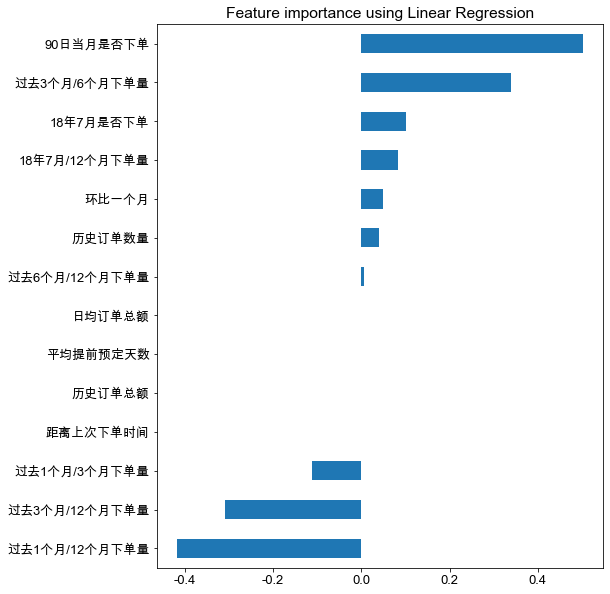

In [102]:
#feature importance plot
coef = pd.Series(lm.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression")

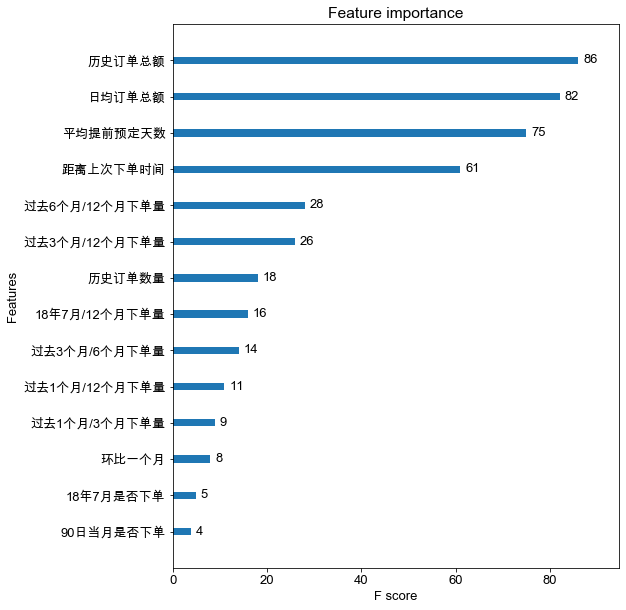

In [103]:
xgb.plot_importance(model1,max_num_features=20,height=0.2,grid=False)